In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from plotting import plot_utils, load_fits, summary_plots
from utils import roi_utils, default_paths
from feature_extraction import gabor_feature_extractor


#### Load model fits

In [2]:
subjects = np.arange(1,9)

n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf'

trial_subsets = ['balance_indoor_outdoor','outdoor_only','indoor_only',\
                 'balance_animacy', 'animate_only', 'inanimate_only',\
                 'balance_real_world_size_binary','large_only', 'small_only']

n_trial_subsets = len(trial_subsets)

out_all = []
for ti, ts in enumerate(trial_subsets):
    
    if ts=='all_trials':
        ft = fitting_type
    else:
        ft ='%s_%s'%(fitting_type, ts)

    out = [load_fits.load_fit_results(subject=ss, fitting_type=ft, \
                                      n_from_end=0, \
                                  verbose=False) \
           for ss in subjects]
    out_all.append(out)
    
out = out_all

fig_save_folder=None

roi_def = roi_utils.multi_subject_roi_def(subjects, \
                                          remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

#### Get info about the Gabor feature space

In [3]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### threshold voxels within groups by R2

groups are one semantic axis at a time. 

For instance, group 1 is [balanced indoor outdoor/just outdoor/just indoor], each w same number of trials.
Always use the same set of voxels when comparing within a group, so threshold them each here.

In [4]:

subsets2group = [[0,1,2], [3,4,5], [6,7,8]];
group_names=[trial_subsets[ti].split('balance_')[1] for ti in [0,3,6]]
n_groups = 3;

group_inds = [np.where([ti in group for group in subsets2group])[0][0] \
    for ti in range(n_trial_subsets)]

voxels_use = [ [[] for ss in subjects] for ai in range(n_groups)]

for si, subject in enumerate(subjects):

    for gi, group in enumerate(subsets2group):
               
        # using all voxels with R2 above threshold for all fits in this group
        # make matrix [n_voxels x 3]
        val_r2_alltrials = np.array([out[xi][si]['val_r2'][:,0] for xi in group])
    
        voxels_use[gi][si] = np.all(val_r2_alltrials>0.01, axis=0)        
        

#### organizing the feature sensitivity values for each voxel

matrix [n_voxels_total x n_channels x n_trial_subsets]

In [5]:
feature_corr = np.moveaxis(np.array([np.concatenate([out[fi][si]['corr_each_feature'] \
                                for si in range(n_subjects)], axis=0) \
                for fi in range(n_trial_subsets)]), [0,1,2], [2,0,1])

n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf, n_trial_subsets], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes. if they are constant across orient/SF, then set to nan.
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1,:], [1,n_ori,1])==mean_orient_corr, axis=1)
assert(not np.any(is_constant))

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1,:], [1,n_sf,1])==mean_sf_corr, axis=1)
assert(not np.any(is_constant))


#### How similar is sensitivity profile across different categories?
Compare levels of each semantic axis - indoor only vs outdoor only, etc

In [6]:
corr_between_methods = np.zeros((n_voxels, n_groups))
compare_names = [[] for gi in range(n_groups)]
for gi, group in enumerate(subsets2group):
    ti1 = group[1]; ti2 = group[2];
    print([ti1, ti2])
    compare_names[gi] = '%s vs. %s'%(trial_subsets[ti1], trial_subsets[ti2])
    
    corr_between_methods[:,gi] = np.array([np.corrcoef(feature_corr[vv,:,ti1], \
                                                 feature_corr[vv,:,ti2])[0,1] \
                                 for vv in range(n_voxels)])

[1, 2]
[4, 5]
[7, 8]


In [7]:
# Averaging these values within ROI

n_vox_each_subj = [out[0][si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

avg_corr_bw_methods = np.zeros((n_rois, n_subjects, n_groups))
for rr in range(n_rois):
    for ss in range(n_subjects):
        for gi in range(n_groups):
            inds_this_roi = roi_def.get_indices(rr) \
                & (subject_inds==ss) \
                & np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
           
            avg_corr_bw_methods[rr,ss,gi] = \
                np.mean(corr_between_methods[inds_this_roi,gi], axis=0)

#### make a summary plot of the correlation coefficients

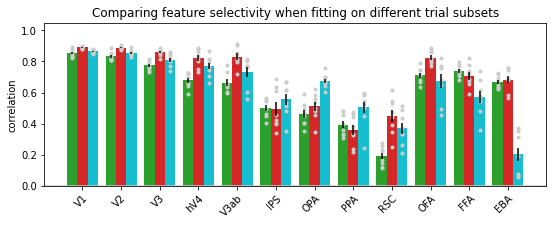

In [8]:
mean_vals = np.mean(avg_corr_bw_methods, axis=1)
sem_vals = np.std(avg_corr_bw_methods, axis=1)/np.sqrt(n_subjects)

colors = cm.tab10(np.linspace(0,1,10))[[2, 3, 9],:]

names = ['indoor only vs. outdoor only']
plt.rcParams['pdf.fonttype']=42
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=np.moveaxis(avg_corr_bw_methods, \
                                                       [0,1,2], [1,0,2]), \
                                space=0.1, \
                xticklabels=roi_names, ylabel='correlation', \
                ylim=[0,1.05], title='Comparing feature sensitivity when fitting on different trial subsets',\
                colors=colors, \
                fig_size=(9,3), 
                legend_separate=False, 
                legend_labels=compare_names)

fn2save = os.path.join(default_paths.fig_path, 'Similarity_featuretuning_acrosscategory.pdf')
plt.savefig(fn2save)


#### Plot distributions of preferred orientation
Just category-selective areas, all image subset splits

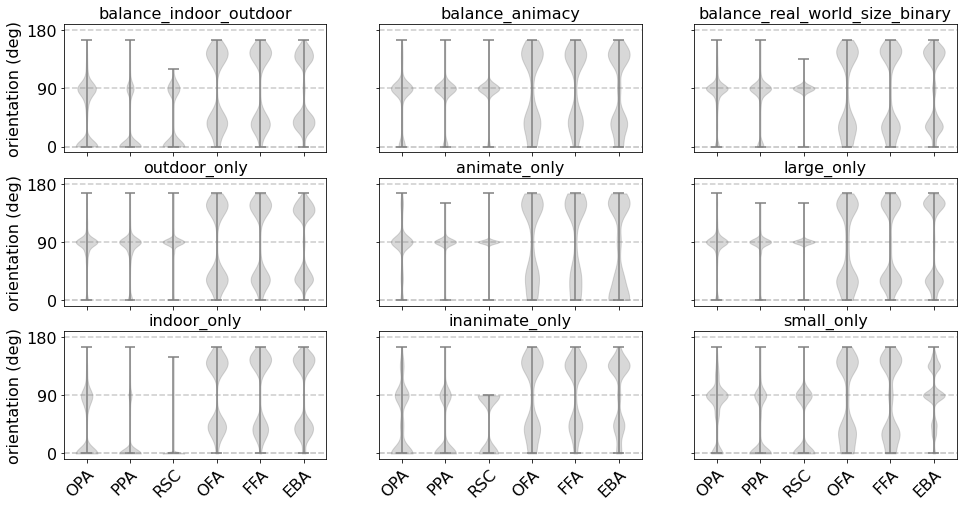

In [9]:
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'

rois2plot = [6,7,8,9,10,11]
plot_inds = [0,3,6,1,4,7,2,5,8]

plt.figure(figsize=(16,8))

for ti in range(n_trial_subsets):

    gi = [gi for gi in range(3) if ti in subsets2group[gi]][0]
   
    plt.subplot(3,3,plot_inds[ti]+1)
    
    for ri, rr in enumerate(rois2plot):
       
        inds_this_roi = roi_def.get_indices(rr) & \
            np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
           
        parts = plt.violinplot(ori_unique[preferred_ori_corr[inds_this_roi,ti].astype(int)],[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)

    
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    if np.mod(plot_inds[ti],3)==0:
        plt.ylabel('orientation (deg)')
        plt.yticks([0,90,180])
    else:
        plt.yticks([0,90,180], labels=[])
        
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    if plot_inds[ti]>5:
        plt.xticks(ticks=np.arange(0,len(rois2plot)),labels=np.array(roi_names)[rois2plot],\
                           rotation=45, ha='right',rotation_mode='anchor')
    else:
        plt.xticks(ticks=np.arange(0,len(rois2plot)),labels=[])
        
    plt.title('%s'%trial_subsets[ti])

fn2save = os.path.join(default_paths.fig_path, 'Gabor_orient_violin_trialsubsets.pdf')
plt.savefig(fn2save)

#### Plot all ROIs

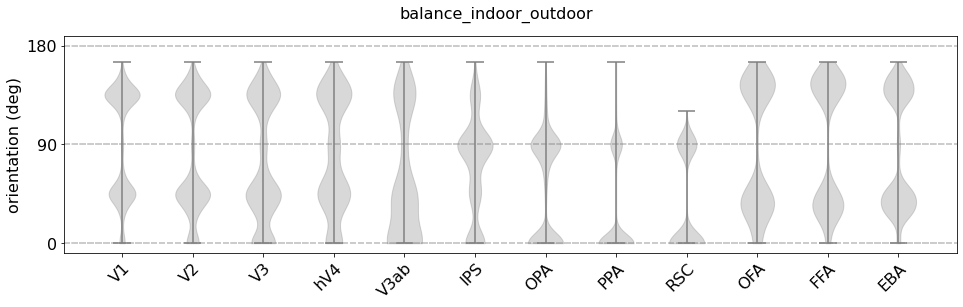

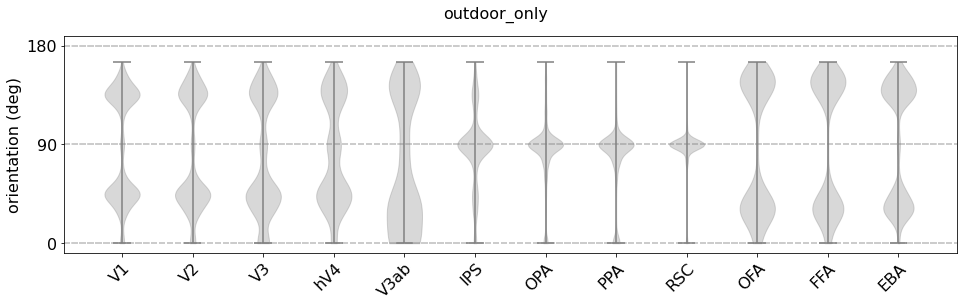

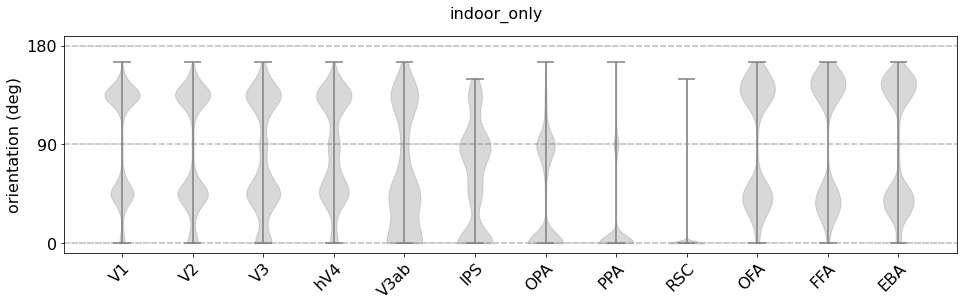

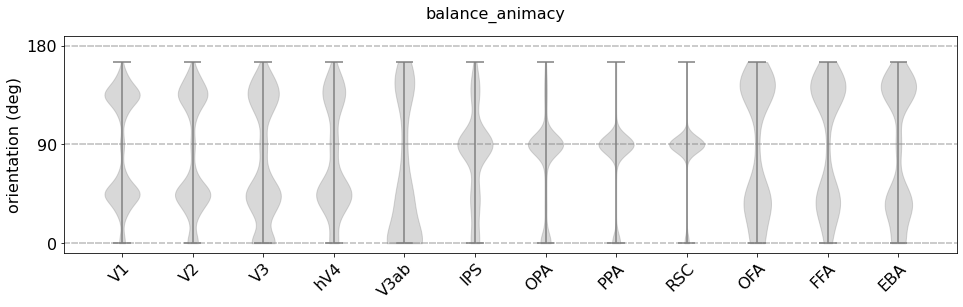

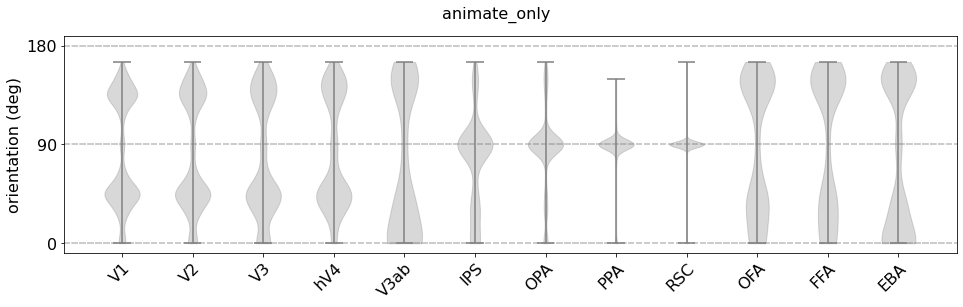

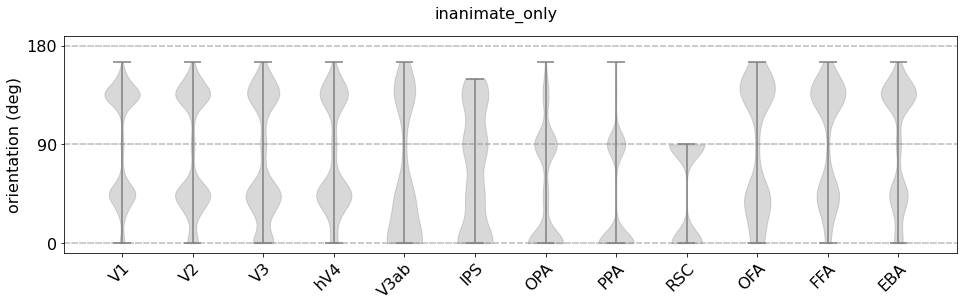

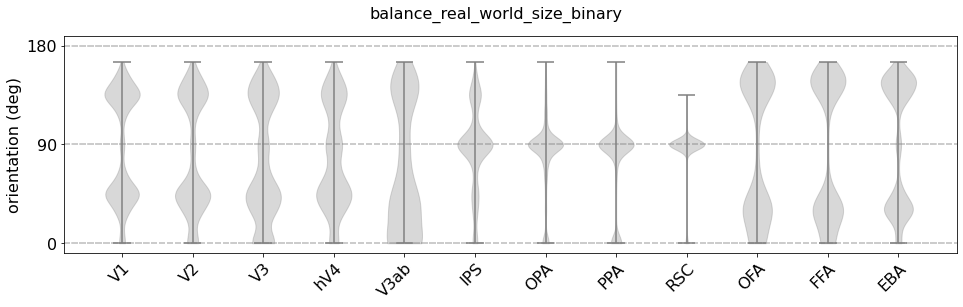

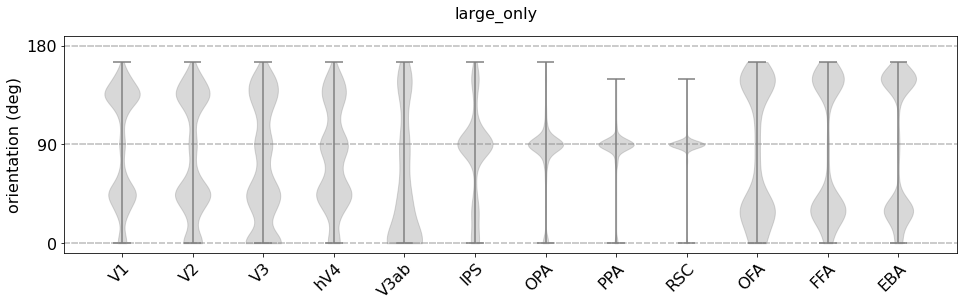

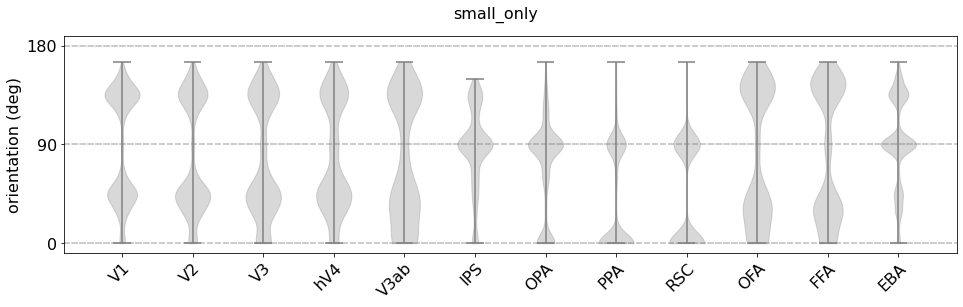

In [10]:
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'

for ti in range(n_trial_subsets):

    gi = [gi for gi in range(3) if ti in subsets2group[gi]][0]
       
    plt.figure(figsize=(16,4))

    for ri in range(n_rois):
        
        inds_this_roi = roi_def.get_indices(ri) & \
            np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
           
        parts = plt.violinplot(ori_unique[preferred_ori_corr[inds_this_roi,ti].astype(int)],[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)

        plt.yticks([0,90,180])
        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
        plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
        plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

        plt.ylabel('orientation (deg)')

        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                           rotation=45, ha='right',rotation_mode='anchor')

    plt.suptitle('%s'%trial_subsets[ti])

    # fn2save = '/user_data/mmhender/imStat/figures/Gabor_orient_violin.pdf'
    # plt.savefig(fn2save)

#### Plot distributions of preferred frequency
Plot just category-selective areas, subplots

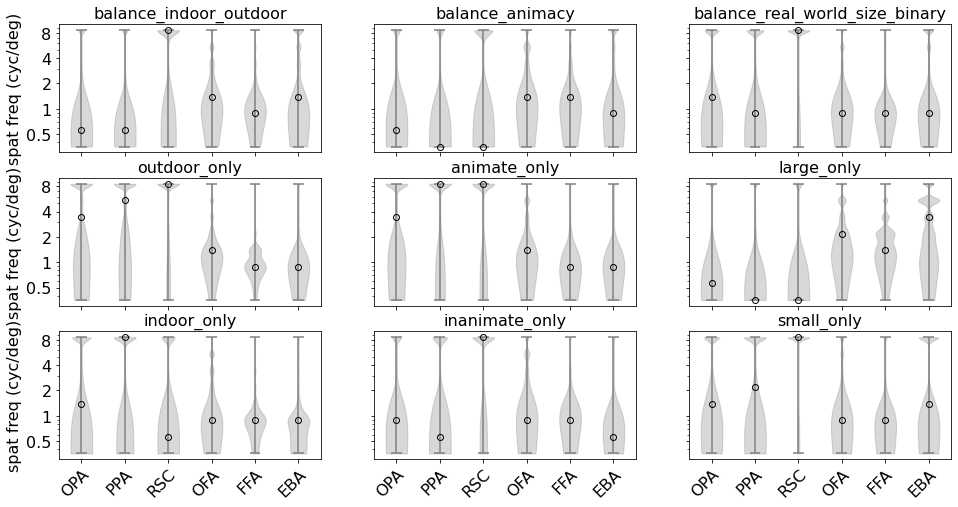

In [11]:
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'

rois2plot = [6,7,8,9,10,11]
plot_inds = [0,3,6,1,4,7,2,5,8]

plt.figure(figsize=(16,8))

for ti in range(n_trial_subsets):

    gi = [gi for gi in range(3) if ti in subsets2group[gi]][0]
   
    plt.subplot(3,3,plot_inds[ti]+1)
    
    for ri, rr in enumerate(rois2plot):
        
        inds_this_roi = roi_def.get_indices(rr) & \
            np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
           
        vals = sf_unique[preferred_sf_corr[inds_this_roi,ti].astype(int)]
        parts = plt.violinplot(vals,[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)
        plt.plot(ri, np.median(vals),'o',color='k',markerfacecolor='none')

    plt.gca().set_yscale('log')
    if np.mod(plot_inds[ti],3)==0:
        plt.ylabel('spat freq (cyc/deg)')

        plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                10**np.log10(2),10**np.log10(4), \
                10**np.log10(8)],\
               [0.5,1,2,4,8])

        
    else:
        plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                10**np.log10(2),10**np.log10(4), \
                10**np.log10(8)],\
               [])

        
    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    if plot_inds[ti]>5:
        plt.xticks(ticks=np.arange(0,len(rois2plot)),labels=np.array(roi_names)[rois2plot],\
                           rotation=45, ha='right',rotation_mode='anchor')
    else:
        plt.xticks(ticks=np.arange(0,len(rois2plot)),labels=[])
        
    plt.title('%s'%trial_subsets[ti])

fn2save = os.path.join(default_paths.fig_path, 'Gabor_freq_violin_trialsubsets.pdf')
plt.savefig(fn2save)

#### All ROIs

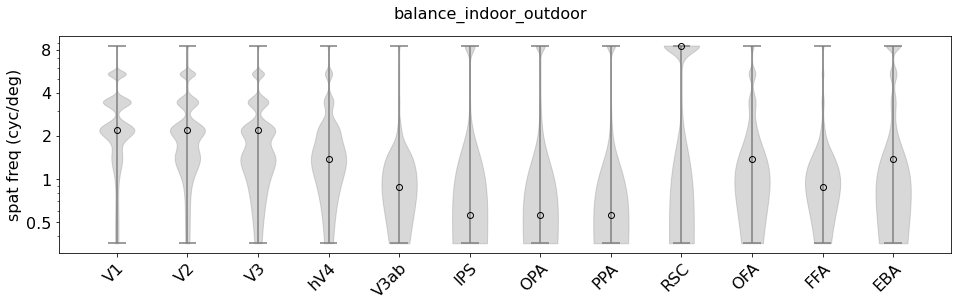

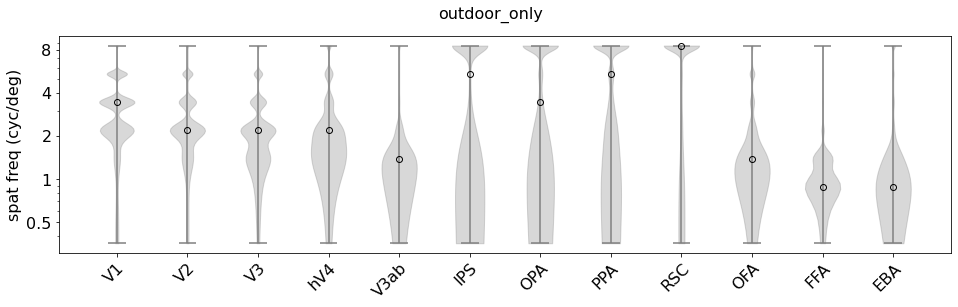

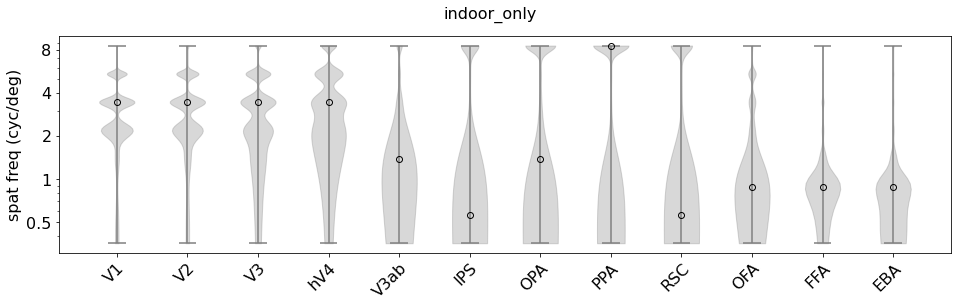

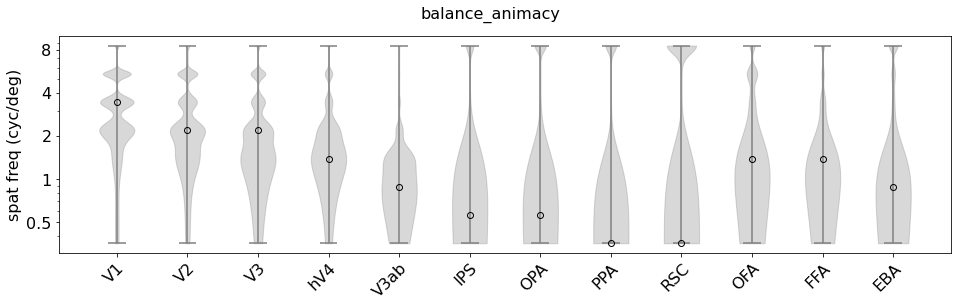

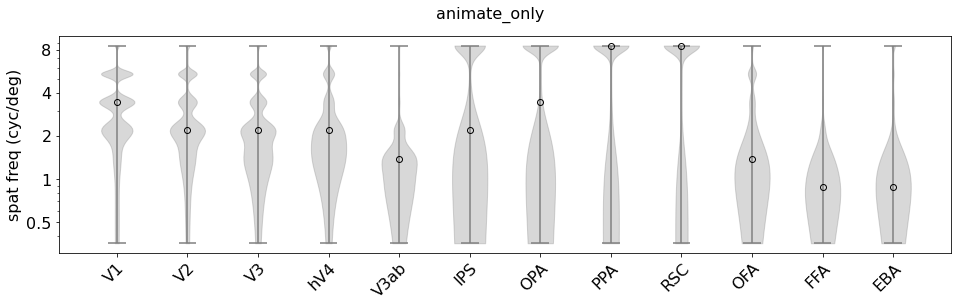

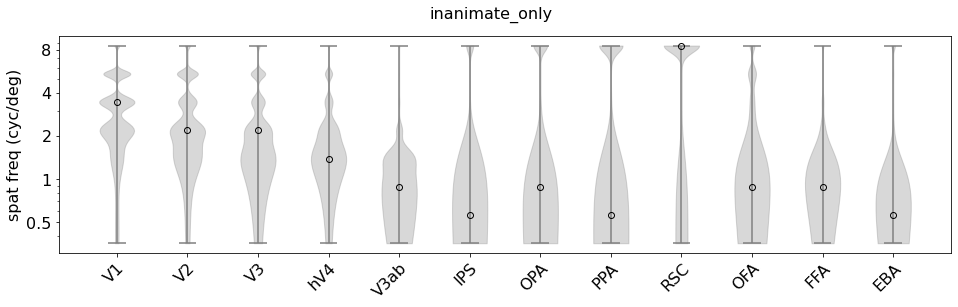

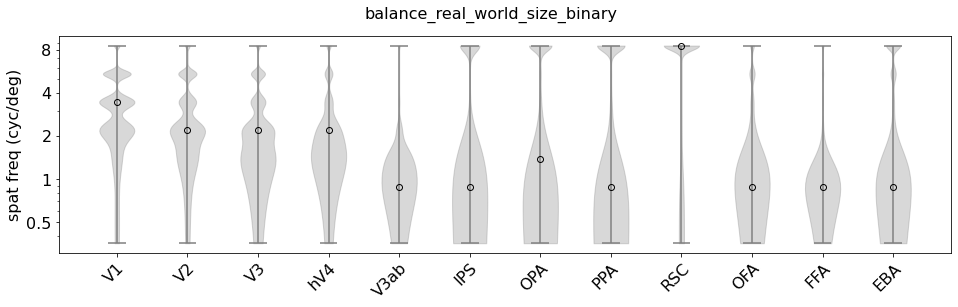

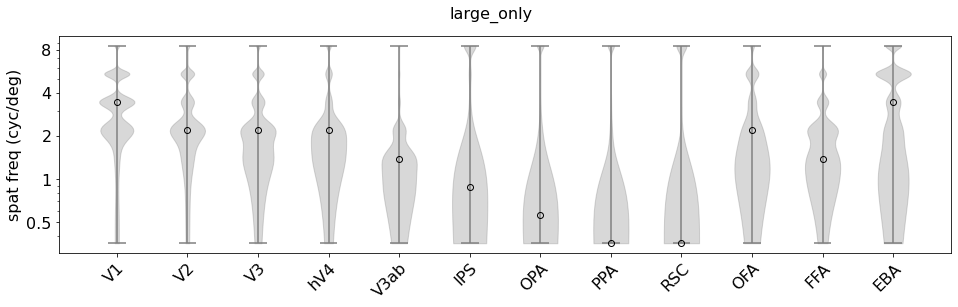

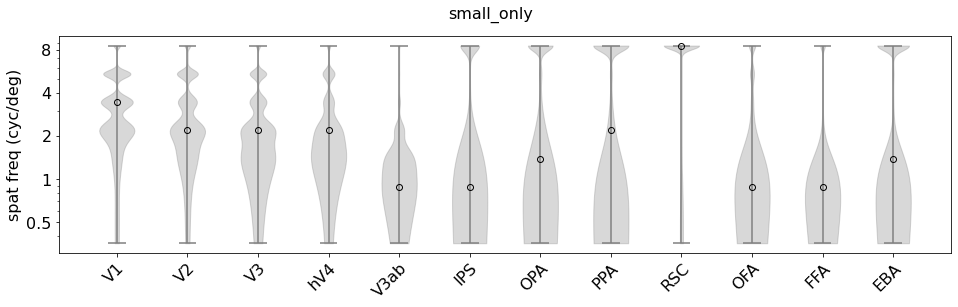

In [12]:
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42

color = '#7f7f7f'

for ti in range(n_trial_subsets):

    gi = [gi for gi in range(3) if ti in subsets2group[gi]][0]
    
    plt.figure(figsize=(16,4))

    for ri in range(n_rois):
        
        inds_this_roi = roi_def.get_indices(ri) & \
            np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)
           
        vals = sf_unique[preferred_sf_corr[inds_this_roi,ti].astype(int)]
        parts = plt.violinplot(vals,[ri])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)
        plt.plot(ri, np.median(vals),'o',color='k',markerfacecolor='none')

        plt.yticks([0,4,8])

        plt.ylabel('spat freq (cyc/deg)')
        plt.gca().set_yscale('log')
        plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
                10**np.log10(2),10**np.log10(4), \
                10**np.log10(8)],\
               [0.5,1,2,4,8])
        plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)

    plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                           rotation=45, ha='right',rotation_mode='anchor')

    plt.suptitle('%s'%trial_subsets[ti])

#### Plots for just single ROIs

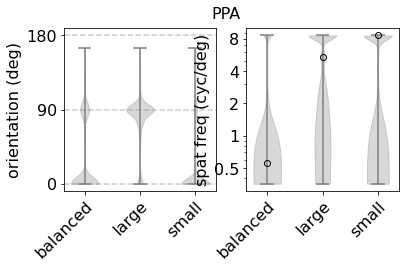

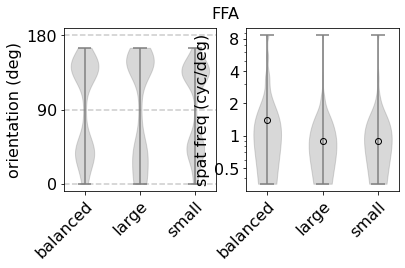

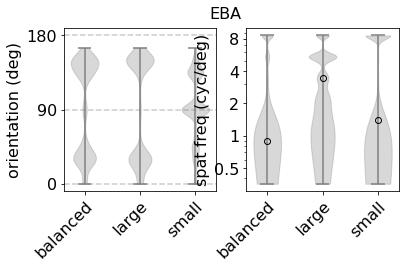

In [13]:
color = '#7f7f7f'

for rr, gi in zip([7,10,11], [0,1,2]):
    

    inds_this_roi = roi_def.get_indices(rr) & \
                np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0)

    names = ['balanced', 'large', 'small']
    groupname = trial_subsets[subsets2group[gi][0]].split('balance_')[1]

    plt.figure(figsize=(6,3))

    plt.subplot(1,2,1);

    for ti, tt in enumerate(subsets2group[gi]):

        parts = plt.violinplot(ori_unique[preferred_ori_corr[inds_this_roi,tt].astype(int)],[ti])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)

    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(90,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
    plt.ylabel('orientation (deg)')
    plt.yticks([0,90,180]);

    plt.xticks(ticks=np.arange(0,len(subsets2group[gi])),\
                           labels=names,\
                           rotation=45, ha='right',rotation_mode='anchor');

    plt.subplot(1,2,2);

    for ti, tt in enumerate(subsets2group[gi]):

        vals = sf_unique[preferred_sf_corr[inds_this_roi,tt].astype(int)]
        parts = plt.violinplot(vals,[ti])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)
        plt.plot(ti, np.median(vals),'o',color='k',markerfacecolor='none')

    plt.yticks([0,4,8])
    plt.gca().set_yscale('log')
    plt.yticks([10**np.log10(0.5), 10**np.log10(1), \
            10**np.log10(2),10**np.log10(4), \
            10**np.log10(8)],\
           [0.5,1,2,4,8])
    plt.ylabel('spat freq (cyc/deg)')

    plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)


    plt.xticks(ticks=np.arange(0,len(subsets2group[gi])),\
                           labels=names,\
                           rotation=45, ha='right',rotation_mode='anchor');

    plt.suptitle(roi_names[rr])
    fn2save = os.path.join(default_paths.fig_path, '%s_sep_%s.pdf'%(roi_names[rr], groupname))
    plt.savefig(fn2save)

#### Now compute ROI-averaged response profiles
For each participant separately

In [14]:
avg_resp_profiles = np.zeros((n_subjects, n_rois, n_ori, n_sf, n_groups, 3))

for si in range(n_subjects):
    for ri in range(n_rois):      
        
        for gi, group in enumerate(subsets2group):
            
            inds_this_roi = roi_def.get_indices(ri) & \
                    np.concatenate([voxels_use[gi][si] for si in range(n_subjects)], axis=0) & \
                    (subject_inds==si)   
            
            for ti, ts in enumerate(group):
                
                avg_resp_profiles[si,ri,:,:,gi,ti] = np.mean(allcorr_reshaped[inds_this_roi,:,:,ts], axis=0)

#### Define some colors, for plotting feature sensitivity profiles

In [15]:
colors_outdoor = np.flipud(cm.Greens(np.linspace(0,1,3))[1:3,:])
colors_outdoor = np.concatenate([np.array([[0.6, 0.6, 0.6, 1]]), colors_outdoor], axis=0)

colors_animacy = np.flipud(cm.Reds(np.linspace(0,1,5))[[1,3],:])
colors_animacy = np.concatenate([np.array([[0.6, 0.6, 0.6, 1]]), colors_animacy], axis=0)

colors_size = np.flipud(cm.Blues(np.linspace(0,1,3))[1:3,:])
colors_size = np.concatenate([np.array([[0.6, 0.6, 0.6, 1]]), colors_size], axis=0)

colors_categ = [colors_outdoor, colors_animacy, colors_size]

#### Plot sensitivity profiles, for just a few example ROIs

['balance_indoor_outdoor' 'outdoor_only' 'indoor_only']
/user_data/mmhender/image_stats_gabor/figures/Profiles_PPA_sep_indoor_outdoor.pdf
['balance_animacy' 'animate_only' 'inanimate_only']
/user_data/mmhender/image_stats_gabor/figures/Profiles_FFA_sep_animacy.pdf
['balance_real_world_size_binary' 'large_only' 'small_only']
/user_data/mmhender/image_stats_gabor/figures/Profiles_EBA_sep_real_world_size_binary.pdf


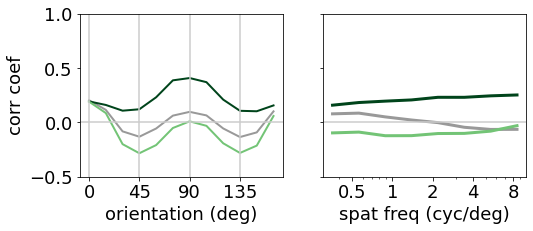

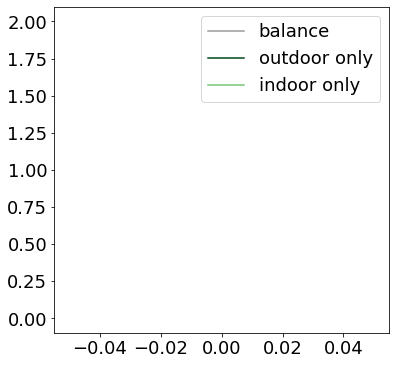

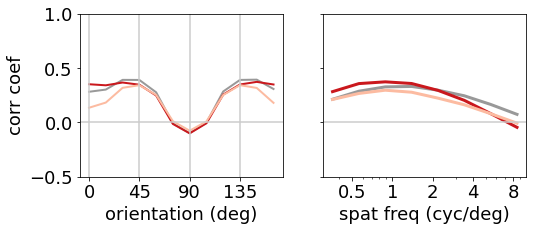

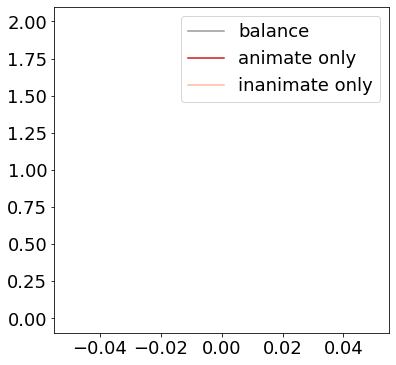

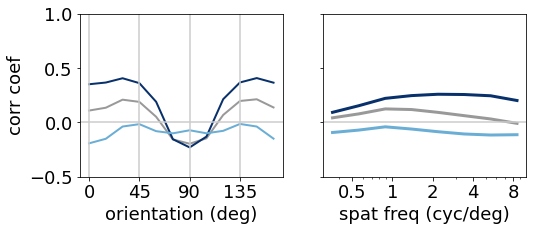

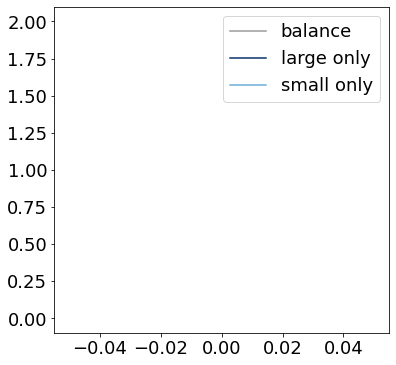

In [16]:
rr2plot = [7,10,11]
gi2plot = [0,1,2]
names_list =[ ['balance', 'outdoor only', 'indoor only'], \
           ['balance', 'animate only', 'inanimate only'], \
             ['balance', 'large only', 'small only']]
plot_utils.set_all_font_sizes(18)

             
for rr, gi, names in zip(rr2plot, gi2plot, names_list):


    print(np.array(trial_subsets)[subsets2group[gi]])

    groupname = trial_subsets[subsets2group[gi][0]].split('balance_')[1]

    colors = colors_categ[gi]

    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    for ti, tt in enumerate(subsets2group[gi]):

        vals = np.mean(np.mean(avg_resp_profiles[:,rr,:,:,gi,ti] , axis=0), axis=1)
 
        plt.plot(ori_unique,  vals,\
                 '-',color=colors[ti,:],linewidth=2)

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5, 1.0])

    plt.xlabel('orientation (deg)')
    plt.ylabel('corr coef')
    plt.xticks(np.arange(0,180,45))

    for ii in np.arange(0,180,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.subplot(1,2,2)
    for ti, tt in enumerate(subsets2group[gi]):

        vals = np.mean(np.mean(avg_resp_profiles[:,rr,:,:,gi,ti] , axis=0), axis=0)
 
        plt.plot(sf_unique,  vals,\
                     '-',color=colors[ti,:],linewidth=3)

    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.ylim([-0.5,1])
    plt.xticks([0,4,8])
    plt.yticks([-0.5, 0, 0.5, 1], labels=[])
    plt.xlabel('spat freq (cyc/deg)')
    plt.gca().set_xscale('log')
    plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                10**np.log10(2),10**np.log10(4), \
                10**np.log10(8)],\
               [0.5,1,2,4,8])
    # plt.ylabel('corr coef')

    fn2save = os.path.join(default_paths.fig_path, 'Profiles_%s_sep_%s.pdf'%(roi_names[rr], groupname))
    print(fn2save)
    plt.savefig(fn2save)

    # plot_utils.set_all_font_sizes(10)
    plt.figure(figsize=(6,6));
    for ti, tt in enumerate(subsets2group[gi]):
        plt.plot(0,ti,color=colors[ti,:])    
        plt.legend(names)

#### Plot sensitivity profiles over orientation, for each subset of trials
All ROIs

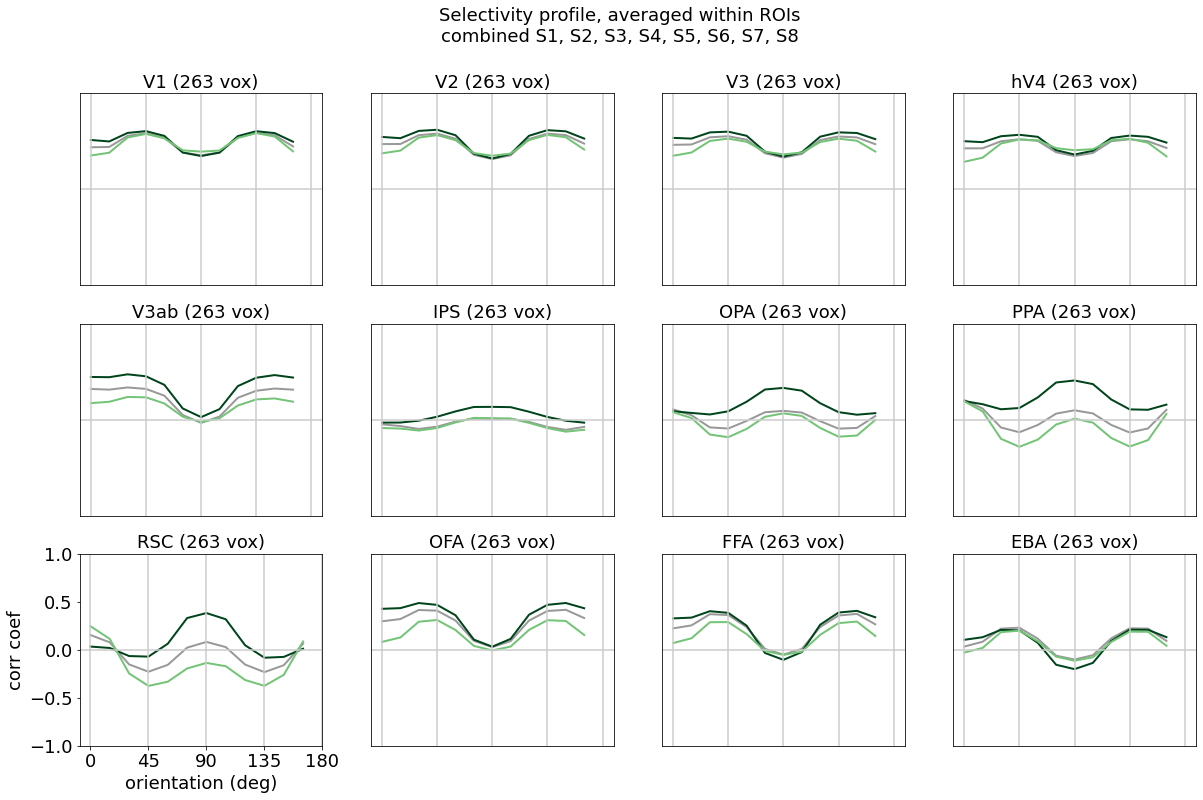

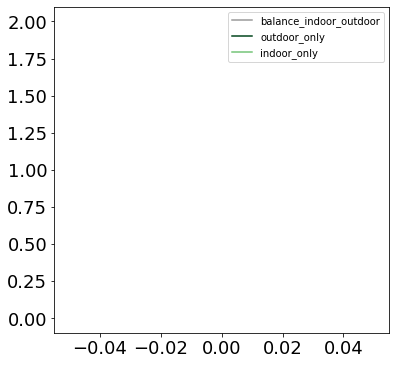

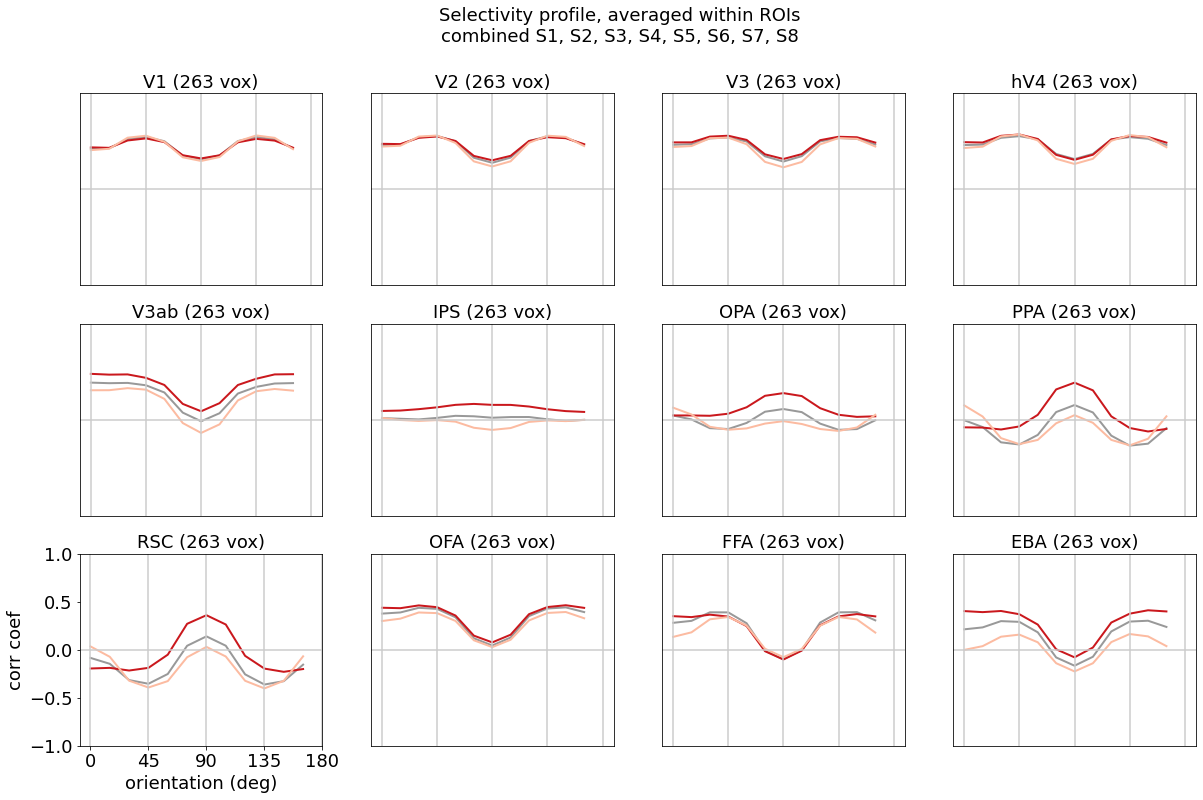

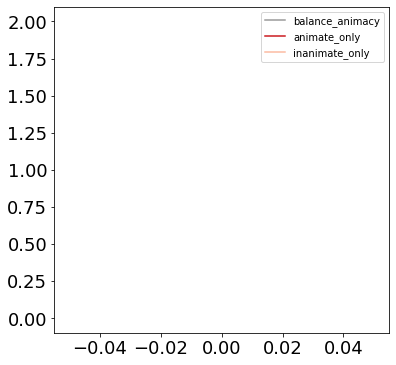

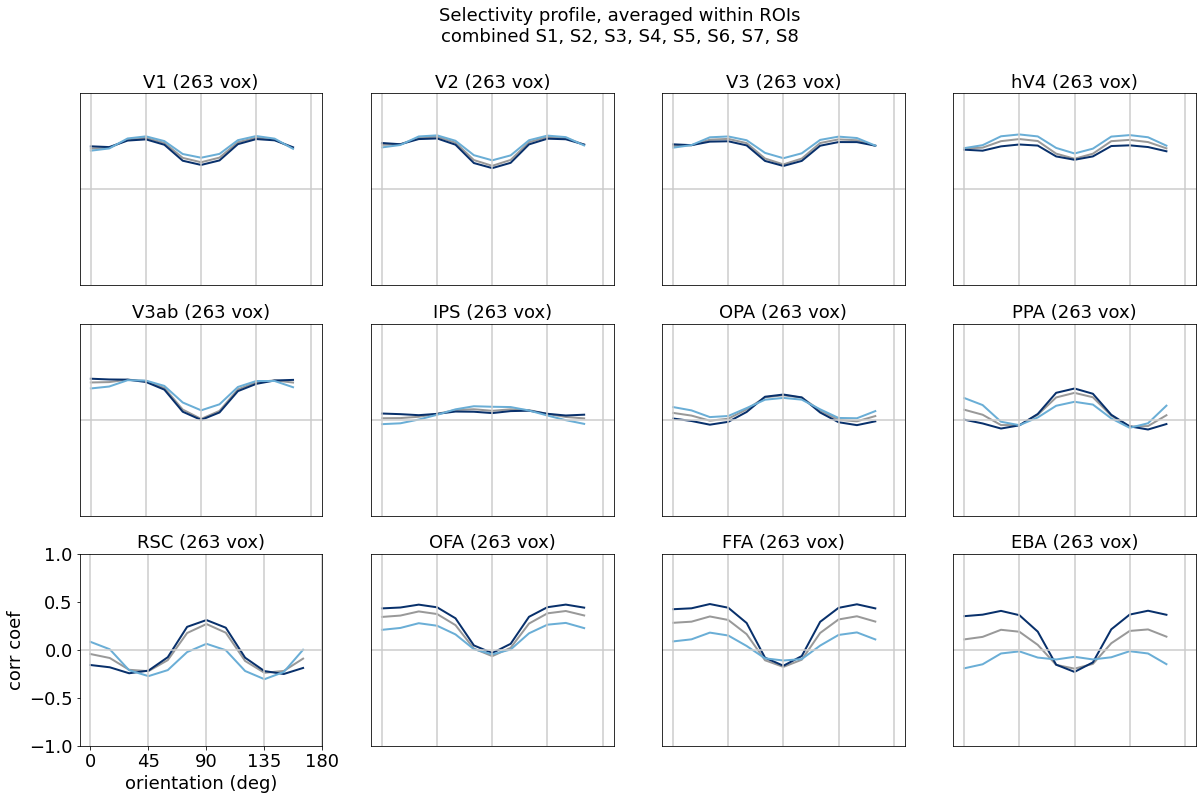

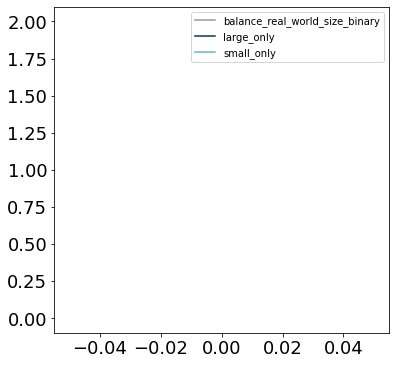

In [17]:
plot_utils.set_all_font_sizes(18)
subsets2group = [[0,1,2], [3,4,5], [6,7,8]];
n_groups = 3;

for gi, group in enumerate(subsets2group):

    plt.figure(figsize=(20,12))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))

    colors = colors_categ[gi]
    
    for rr in range(n_rois):

        for ti, ts in enumerate(group):
            
            vals = np.mean(np.mean(avg_resp_profiles[:,rr,:,:,gi,ti] , axis=0), axis=1)
 
            pi = rr+1;
            plt.subplot(npx,npy,pi)

            plt.plot(ori_unique,  vals,\
                     '-',color=colors[ti,:],linewidth=2)

        plt.axhline(0, color=[0.8, 0.8, 0.8])
        plt.ylim([-1.0,1.0])

        if pi==(npx-1)*npy+1:
            plt.xlabel('orientation (deg)')
            plt.ylabel('corr coef')
            plt.xticks(np.arange(0,181,45))
        else:
            plt.xticks([]);
            plt.yticks([])

        for ii in np.arange(0,181,45):
            plt.axvline(ii,color=[0.8, 0.8, 0.8])

        plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

    plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out[0]))

    # plot_utils.set_all_font_sizes(10)
    plt.figure(figsize=(6,6));
    for ti, ts in enumerate(group):
        plt.plot(0,ti,color=colors[ti,:])    
    plt.legend(['%s'%trial_subsets[ts] for ts in group], prop={'size':10})
    # plot_utils.set_all_font_sizes(16)

#### Plot sensitivity profiles over frequency, for each subset of trials
All ROIs


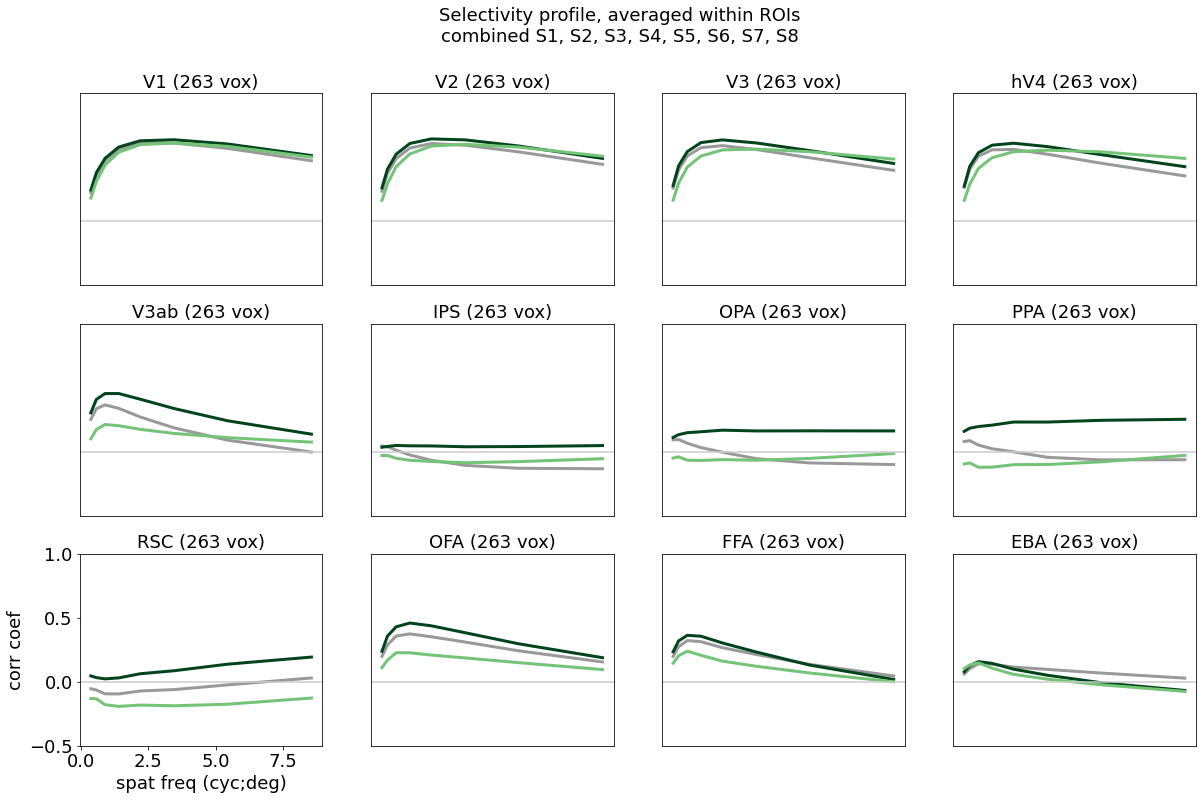

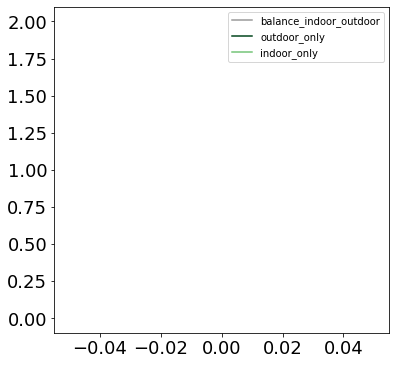

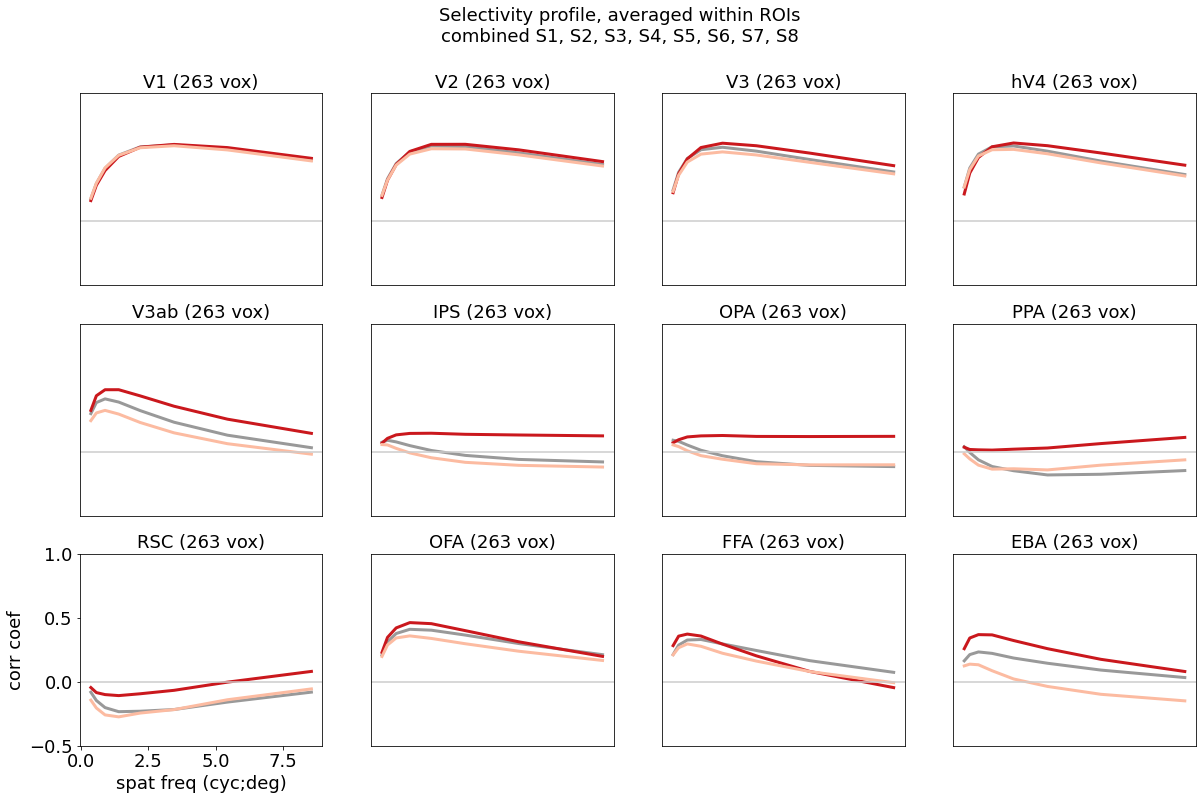

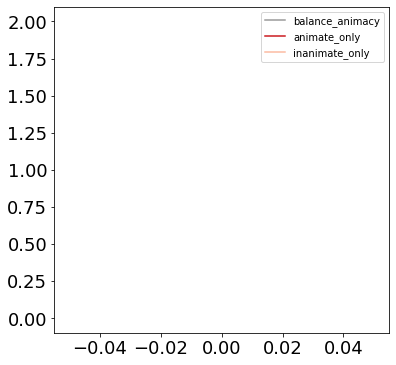

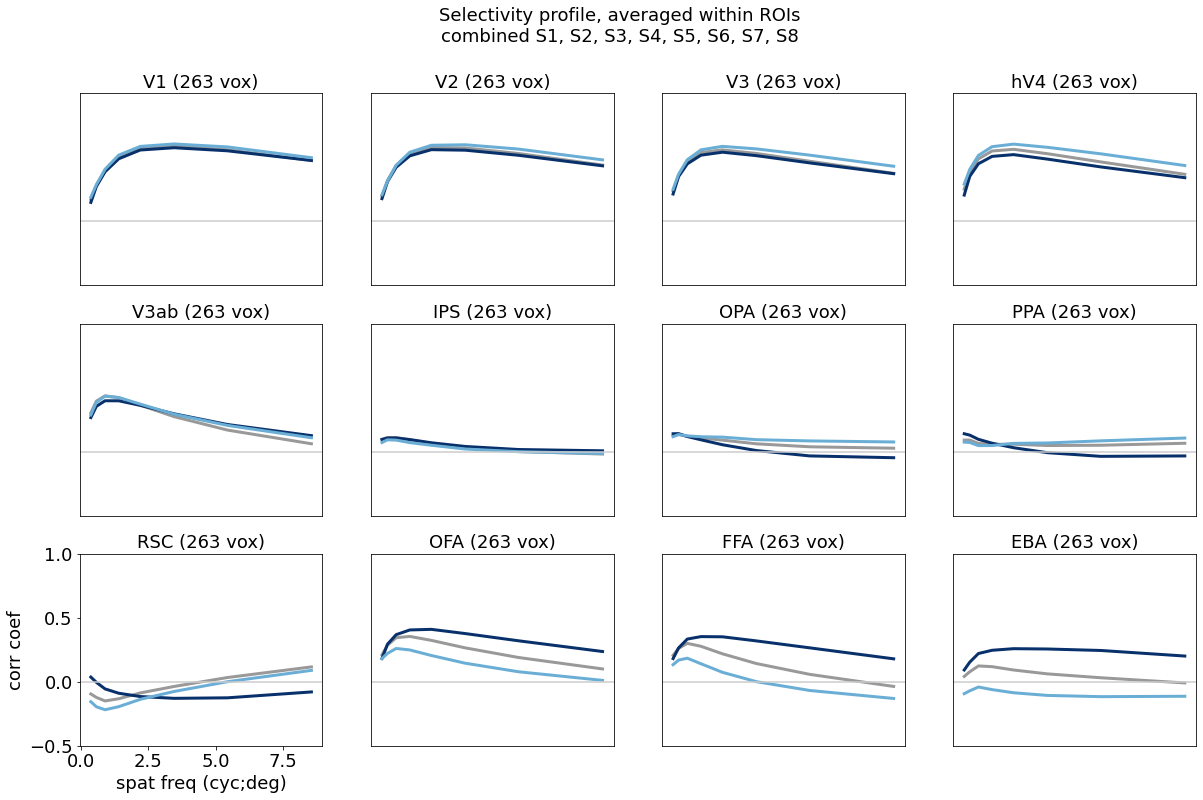

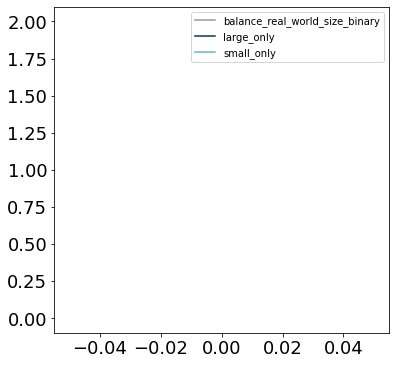

In [18]:
plot_utils.set_all_font_sizes(18)
subsets2group = [[0,1,2], [3,4,5], [6,7,8]];
n_groups = 3;

for gi, group in enumerate(subsets2group):

    plt.figure(figsize=(20,12))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))
    
    colors = colors_categ[gi]

    for rr in range(n_rois):

        for ti, ts in enumerate(group):
 
            pi = rr+1;
            plt.subplot(npx,npy,pi)

            vals = np.mean(np.mean(avg_resp_profiles[:,rr,:,:,gi,ti] , axis=0), axis=0)
 
            plt.plot(sf_unique,  vals,\
                 '-',color=colors[ti,:],linewidth=3)

        plt.axhline(0, color=[0.8, 0.8, 0.8])
        plt.ylim([-0.5,1])

        if pi==(npx-1)*npy+1:
            plt.xlabel('spat freq (cyc;deg)')
            plt.ylabel('corr coef')
           
        else:
            plt.xticks([]);
            plt.yticks([])

        plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

    plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out[0]))

    # plot_utils.set_all_font_sizes(10)
    plt.figure(figsize=(6,6));
    for ti, ts in enumerate(group):
        plt.plot(0,ti,color=colors[ti,:])    
    plt.legend(['%s'%trial_subsets[ts] for ts in group], prop={'size':10})
    # plot_utils.set_all_font_sizes(16)